In [16]:
import os, re
from pathlib import Path as path
import rasterio as rio
import h5py as h5
from matplotlib import pyplot as plt
import matplotlib.animation as anim
from glob import glob
import numpy as np
import numpy.ma as ma
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
from mpl_toolkits.basemap import Basemap

In [17]:
data_dir = os.path.join('..', 'data', 'testcase5_ldt_obscdf')
rs_data_dir = os.path.join(data_dir, 'RS_DATA')
smap_data_dir = os.path.join(rs_data_dir, 'SMAP', 'SPL3SMP.005')
sm_file_suffix = '*_R16010_001.h5'

ease_grid_dir = os.path.join('..', 'data', 'ease_grid')
ease_lats_path = os.path.join(ease_grid_dir, 'EASE2_M36KM.lats.964x406x1.double')
ease_lons_path = os.path.join(ease_grid_dir, 'EASE2_M36KM.lons.964x406x1.double')

plot_out_dir = os.path.join('..', 'data', 'output', 'sm_anim_frames')

sm_name = 'soil_moisture'

test_data_path = os.path.join(rs_data_dir, 'SMAP', 'SPL3SMP.005', '2017.03.01', 'SMAP_L3_SM_P_20170301_R16010_001.h5')

# get paths to all h5 files
data_paths = sorted([str(fp) for fp in path(smap_data_dir).rglob(sm_file_suffix)])

ease_epsg = 'epsg:3410'
wgs84_epsg = 'epsg:3426'

In [18]:
lats = np.fromfile(ease_lats_path, dtype=np.float64).reshape((406, 964)) #< reshape to dimensions above
lons = np.fromfile(ease_lons_path, dtype=np.float64).reshape((406, 964))

In [19]:
test_data_path.split('/')[-2]

'2017.03.01'

In [20]:
def print_dataset_names(src_path: str):
    with rio.open(src_path) as src:
        subdatasets = src.subdatasets
        for name in subdatasets:
            print(name)

In [21]:
def read_dataset(src_path: str, dataset_name: str, mask_nodata: bool=True):
    with rio.open(src_path) as src:
        subdatasets = src.subdatasets
        data = ''
        lat = ''
        lon = ''
        for path in subdatasets:
            name = path.split('/')[-1]
            if name == dataset_name:
                with rio.open(path) as subdataset:
                    data = subdataset.read(1)
                    meta = subdataset.meta
                    desc = subdataset.tags(bidx=1) # additional metadata (e.g., units)
                    meta['crs'] = ease_epsg

                    if mask_nodata:
                        data = ma.masked_where(data == meta['nodata'], data)
            
    return data, meta, desc

In [22]:
def read_coords(src_path: str, dataset_name: str):
    with rio.open(src_path) as src:
        subdatasets = src.subdatasets
        lat = ''
        lon = ''
        for path in subdatasets:
            name = path.split('/')[-1]
            if name == 'longitude':
                with rio.open(path) as subdataset:
                    lon = subdataset.read(1)
            elif name == 'latitude':
                with rio.open(path) as subdataset:
                    lat = subdataset.read(1)
            
    return lat, lon

In [23]:
def plot_data(data: np.ndarray):
    data, meta = read_dataset(src_path, dataset_name)

    fig, ax = plt.subplots(figsize=(30, 10))
    plot = plt.imshow(masked_data, cmap='viridis_r', ax=ax)
    
    return plot

In [24]:
def create_sm_plots(data_filepaths: list, dataset_name: str):
    plots = []
    for fp in data_filepaths:
        plots.append(plot_data(fp, dataset_name))
    return plots

In [25]:
def plot_sm_data(src_path: str):
    print(f'plotting {src_path}')
    plot_data(src_path, sm_name)

In [26]:
def save_plots(data_filepaths, dataset_name):
    for fp in data_filepaths:
        plot_date = fp.split('/')[-2]
        plot = plot_data(fp, dataset_name)
        plt.title(plot_date)
        
        out_fp = os.path.join(plot_out_dir, f'{plot_date}.png')
        plt.savefig(out_fp)

In [27]:
def plot_data_robin(src_path: str, dataset_name: str):
    data, meta, units = read_dataset(src_path, dataset_name)
    lat, lon = read_coords(src_path, dataset_name)

    fig, ax = plt.subplots(figsize=(30, 10))
    
    map_plot = Basemap(projection='robin', resolution='c', lat_0=0, lon_0=0)
    xi, yi = map_plot(lon, lat)
    cs = map_plot.pcolor(xi, yi, masked_data, cmap='terrain_r')

    map_plot.colorbar(mappable=cs, location='bottom')
    map_plot.drawcoastlines()
    map_plot.drawcountries()

    paralells = np.arange(-90, 91, 30)
    meridians = np.arange(-180, 180, 30)
    labels=[True for i in paralells]

    map_plot.drawparallels(paralells, color='gray', labels=labels)
    map_plot.drawmeridians(meridians, color='gray', labels=labels)
    map_plot.drawlsmask(ocean_color='lightblue')
    
    plt.tight_layout()
    

In [28]:
def plot_data_cyl(data: np.ndarray, meta: dict, lat: np.ndarray, lon: np.ndarray, dataset_name: str, dataset_desc: dict):

    long_name, units, vmin, vmax = (None, None, None, None)

    for descriptor in dataset_desc.keys():
        if 'long_name' in descriptor:
            long_name = dataset_desc[descriptor]
        elif 'units' in descriptor:
            units = dataset_desc[descriptor]
        elif 'valid_min' in descriptor:
            vmin = dataset_desc[descriptor]
        elif 'valid_max' in descriptor:
            vmax = dataset_desc[descriptor]

    fig, ax = plt.subplots(figsize=(30, 10))

    ax.set_title(long_name.split('.')[0].upper(), pad=40)

    map_plot = Basemap(projection='cyl', resolution='l', ax=ax)
    xi, yi = map_plot(lon, lat)

    cs = map_plot.pcolor(lon, lat, data, latlon=True, cmap='viridis_r', vmin=vmin, vmax=vmax)
    cbar = map_plot.colorbar(mappable=cs, location='bottom', pad='5%')
    cbar.set_label(f'{dataset_name.upper()} ({units})')
    map_plot.drawcoastlines()
    map_plot.drawcountries()

    paralells = np.arange(-90, 91, 30)
    meridians = np.arange(-180, 180, 30)
    labels=[True for i in paralells]

    map_plot.drawparallels(paralells, color='gray', labels=labels)
    map_plot.drawmeridians(meridians, color='gray', labels=labels)
    map_plot.drawlsmask(ocean_color='lightblue')
    
    # plt.tight_layout()
    

In [29]:
def create_cyl_plot(src_path: str, dataset_name: str):
    data, meta, dataset_desc = read_dataset(src_path, dataset_name, mask_nodata=True)
    lat, lon = read_coords(src_path, dataset_name)
    plot_data_cyl(data, meta, lat, lon, dataset_name, dataset_desc)

In [30]:
# create_cyl_plot(test_data_path, sm_name)

In [31]:
def gen_mean_dataset(src_paths: str, dataset_name: str):

    datasets = []
    meta = None
    desc = None
    for path in src_paths:
        dataset, meta, desc = read_dataset(path, dataset_name, mask_nodata=False)
        dataset[dataset == meta['nodata']] = np.nan
        datasets.append(dataset)
    
    return np.dstack(datasets), meta, desc

In [32]:
test_dataset, test_meta, test_desc = gen_mean_dataset(data_paths, sm_name)

In [33]:
test_dataset.shape

(406, 964, 184)

In [41]:
mean_sm = np.nanmean(test_dataset, axis=2)

In [42]:
mean_sm.shape

(406, 964)

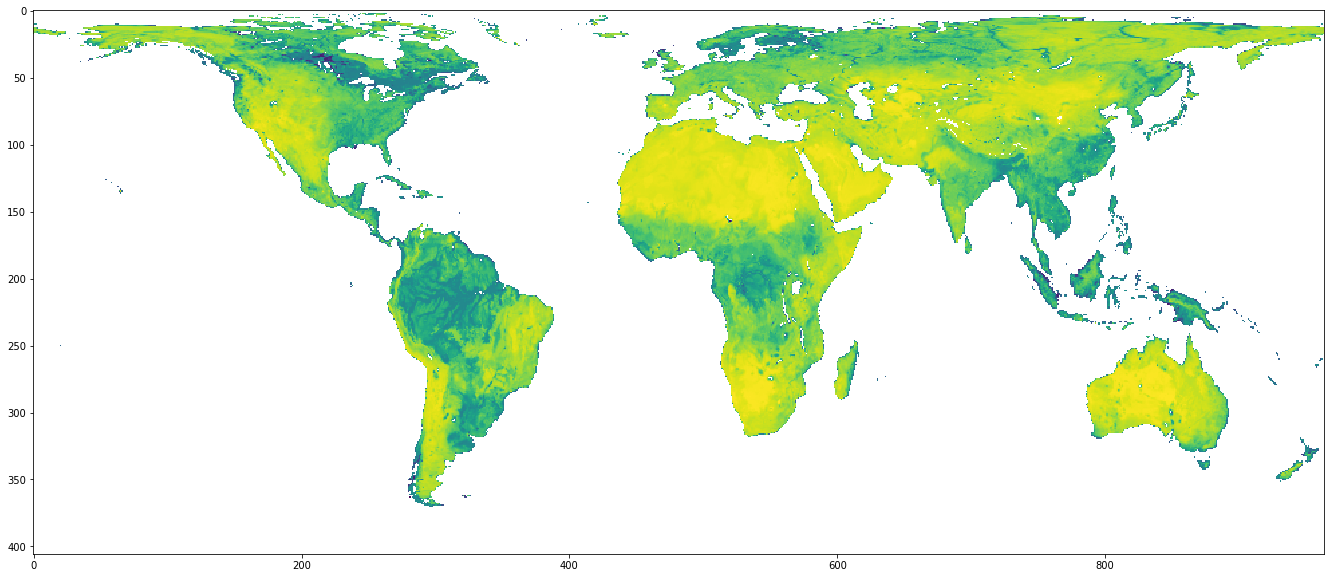

In [43]:
fig, ax = plt.subplots(figsize=(30, 10))
# pos_mean_sm = ma.masked_where(mean_sm < 0, mean_sm)
ax.imshow(mean_sm, cmap='viridis_r')

In [36]:
def plot_data_cyl_test(data: np.ndarray, meta: dict, lat: np.ndarray, lon: np.ndarray):

    fig, ax = plt.subplots(figsize=(30, 10))

    map_plot = Basemap(projection='cyl', resolution='c', ax=ax)
    xi, yi = map_plot(lon, lat)

    cs = map_plot.pcolor(lon, lat, data, latlon=True, cmap='viridis_r', vmin=0.02, vmax=0.5)
    cbar = map_plot.colorbar(mappable=cs, location='bottom', pad='5%')
    map_plot.drawcoastlines()
    map_plot.drawcountries()

    paralells = np.arange(-90, 91, 30)
    meridians = np.arange(-180, 180, 30)
    labels=[True for i in paralells]

    map_plot.drawparallels(paralells, color='gray', labels=labels)
    map_plot.drawmeridians(meridians, color='gray', labels=labels)
    map_plot.drawlsmask(ocean_color='lightblue')
    
    # plt.tight_layout()

In [35]:
def plot_data_robin_test(data: np.ndarray, meta: dict, lat: np.ndarray, lon: np.ndarray):

    fig, ax = plt.subplots(figsize=(30, 10))
    
    map_plot = Basemap(projection='robin', resolution='c', lat_0=0, lon_0=0)
    xi, yi = map_plot(lon, lat)
    cs = map_plot.pcolor(xi, yi, data, cmap='viridis_r')

    map_plot.colorbar(mappable=cs, location='bottom')
    map_plot.drawcoastlines()
    map_plot.drawcountries()

    paralells = np.arange(-90, 91, 30)
    meridians = np.arange(-180, 180, 30)
    labels=[True for i in paralells]

    map_plot.drawparallels(paralells, color='gray', labels=labels)
    map_plot.drawmeridians(meridians, color='gray', labels=labels)
    map_plot.drawlsmask(ocean_color='lightblue')
    
    plt.tight_layout()

In [37]:
# plot_data_cyl_test(mean_sm, test_meta, lats, lons)

In [38]:
test_desc

{'Soil_Moisture_Retrieval_Data_AM_soil_moisture_coordinates': '/Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude',
 'Soil_Moisture_Retrieval_Data_AM_soil_moisture_long_name': 'Representative soil moisture measurement for the Earth based grid cell.',
 'Soil_Moisture_Retrieval_Data_AM_soil_moisture_units': 'cm**3/cm**3',
 'Soil_Moisture_Retrieval_Data_AM_soil_moisture_valid_max': '0.5 ',
 'Soil_Moisture_Retrieval_Data_AM_soil_moisture_valid_min': '0.02 ',
 'Soil_Moisture_Retrieval_Data_AM_soil_moisture__FillValue': '-9999 '}